In [1]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from db_scripts.main_db_script import db_filename
from hr_db_scripts.main_db_script import get_db_table_as_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = get_db_table_as_df('for_model_avgs', dbfilename=db_filename)

In [3]:
print df.shape
df = df[df.rd>0.01]
df.shape

(2172, 20)


(818, 20)

In [4]:
out_col = 'num_flooded'
in_cols = [a for a in df.columns if a not in ['event_date', 'event_name', out_col]]

In [5]:
df[in_cols]
df = df[pd.isnull(df[in_cols]).sum(1)==0]
df.shape

(812, 20)

In [6]:
reg = RandomForestRegressor(oob_score=True, n_estimators=1000, max_features=0.33)
reg.fit(df[in_cols], df[out_col])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.33, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [7]:
preds = reg.predict(df[in_cols])
print r2_score(df.num_flooded, preds)
print mean_absolute_error(df.num_flooded, preds)
print mean_squared_error(df.num_flooded, preds)

0.976902493404
0.296286945813
2.5166796835


(0, 166.95000000000002)

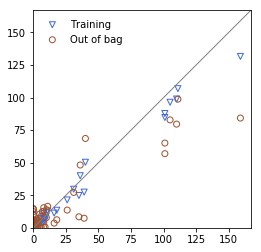

In [8]:
maxval = df[out_col].max()
fig, ax = plt.subplots(1)
ax.plot([0,180], [0,180], c='gray', lw=1)
ax.scatter(df.num_flooded, preds, facecolors='none', edgecolors='royalblue', marker='v', label='Training')
ax.scatter(df.num_flooded, reg.oob_prediction_, marker='o', facecolors='none', edgecolors='sienna', label='Out of bag')
ax.legend(frameon=False)
ax.set_aspect('equal', adjustable='box-forced')
ax.set_xticks(np.arange(0, maxval*2, 25))
ax.set_yticks(np.arange(0, maxval*2, 25))
ax.set_xlim((0, maxval*1.05))
ax.set_ylim((0, maxval*1.05))

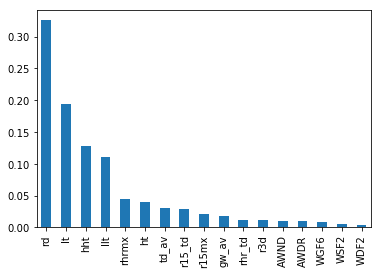

In [9]:
pd.Series(data=reg.feature_importances_, index=in_cols).sort_values(ascending=False).plot.bar()

In [10]:
print r2_score(df.num_flooded, reg.oob_prediction_)
print mean_absolute_error(df.num_flooded, reg.oob_prediction_)
print mean_squared_error(df.num_flooded, reg.oob_prediction_)

0.829826082423
0.804372859364
18.5419685559


## Cross validation

In [11]:
bins = np.linspace(0, 110, 6)

In [12]:
bins

array([   0.,   22.,   44.,   66.,   88.,  110.])

In [13]:
y_binned = np.digitize(df[out_col], bins)

In [14]:
pd.Series(y_binned, dtype='category').value_counts()

1    800
2      6
6      3
5      3
dtype: int64

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df[in_cols], df[out_col], stratify = y_binned, test_size = 0.3)

In [16]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVR(), param_grid=param_grid)
grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
grid

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
'try'

'try'

In [19]:
a = 't'